In [2]:
%reload_ext autoreload
%autoreload 2

from spice_net import *
from helpers import *
from analytic import *

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Generate the uniform inputs 
num_pts = 40
lh = 2

xs = np.linspace(-lh, lh, num_pts)[:, None]
xs_bias = np.hstack((xs, np.ones(xs.shape)))

### Prelim: uniform inputs and implementing our analytic solver

#### Walk through our method on a toy example

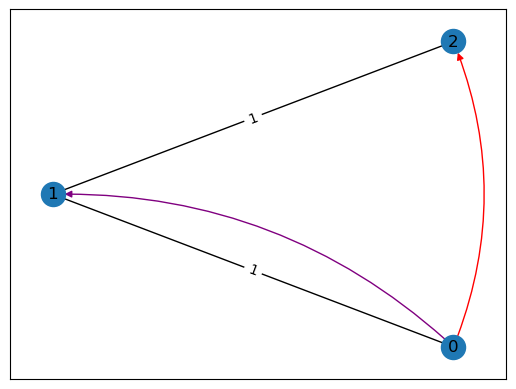

In [3]:
vd_graph = nx.from_numpy_array(np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]))
net = LinearNetwork('voltage_divider', con_graph=vd_graph, node_cfg=(np.array([[2, 0]]), np.array([[1, 0]])), epsilon=1e-16)
visualize(net)

In [4]:
A = gen_A(net, net.inputs)

In [5]:
np.linalg.eigvals(A), np.linalg.det(A)

(array([ 2.73205081,  1.        , -0.73205081]), -2.0)

In [6]:
print(A)

[[ 2. -1.  0.]
 [-1.  1.  1.]
 [ 0.  1.  0.]]


In [7]:
# view our computed voltages compared to SPICE-generated solutions
# NOTE: first node is defined as ground and is implicitly left out. last node represents current through the voltage source.
x = solve(A, [1]) 
x

array([[ 0.5],
       [ 1. ],
       [-0.5]])

In [8]:
net.solve([1]).squeeze()

Note: can't find the initialization file spinit.
Unsupported Ngspice version 38


array([0. , 0.5, 1. ])

#### Test our method against SPICE on many random graphs

In [10]:
# test our implementation on lots of examples
num_examples = 10000
for _ in range(num_examples):
    n = np.random.randint(4, 10)
    k  = np.random.randint(1, n)
    p = 0.5 + (np.random.random()/2)

    in_nodes = out_nodes = 1
    con_graph = nx.erdos_renyi_graph(n=n, p=p, directed=False)
    while not nx.is_connected(con_graph):
        con_graph = nx.erdos_renyi_graph(n=n, p=p, directed=False)

    for u, v in con_graph.edges():
        con_graph[u][v]['type'] = 'resistor'
        con_graph[u][v]['weight'] = np.abs(np.random.normal(1, 0.5))


    node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(n-in_nodes-out_nodes-1))
    node_cfg = np.random.choice(n, size=(in_nodes + out_nodes, 2), replace=False)
    node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

    net = LinearNetwork('test', con_graph, node_cfg)

    A = gen_A(net, net.inputs)
    v_in = np.random.randn(1)

    spice_sol = net.solve(v_in).squeeze()[1:]
    our_sol = solve(A, v_in).squeeze()[:-1]

    assert np.allclose(our_sol, spice_sol), (our_sol, spice_sol)

### 

In [4]:
# Fixed parameters
nodes = 9
edge_prob = .5

in_nodes = 2
out_nodes = 1

num_trials = 10000

boundary_tol = 0.15

In [85]:
slope_vals = []
intercept_vals = []

inside_nets = []
on_nets = []
outside_nets = []

coeff = np.linalg.inv(xs_bias.T @ xs_bias) @ xs_bias.T

In [86]:
X = []
y = []

In [87]:
np.random.seed(0)
for _ in range(num_trials):
    con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=False)
    for i, (u, v) in enumerate(con_graph.edges()):
        con_graph[u][v]['type'] = 'resistor'

    node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
    node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
    node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

    out_plus = node_cfg[1][0][0]
    out_minus = node_cfg[1][0][1]

    weights = np.abs(np.random.normal(1, 0.5, size=con_graph.number_of_edges()))

    for i, (u, v) in enumerate(con_graph.edges()):
        con_graph[u][v]['weight'] = weights[i]

    net = LinearNetwork('test', con_graph, node_cfg)

    A = gen_A(net, net.inputs)
    sol = solve(A, xs_bias.T)
    sol_plus = sol[out_plus-1] if out_plus > 0 else np.zeros(sol[out_plus].shape)
    sol_minus = sol[out_minus-1] if out_minus > 0 else np.zeros(sol[out_minus].shape)
    preds = sol_plus - sol_minus

    # preds = net.predict(xs_bias).squeeze()

    slope, intercept = coeff @ preds

    if abs(slope) + abs(intercept) > 1 + boundary_tol:
        outside_nets.append((net.copy('special'), slope, intercept))
    elif abs(slope) + abs(intercept) > 1:
        on_nets.append((net.copy('special'), slope, intercept))
    elif len(inside_nets) < 10:
        inside_nets.append((net.copy('nonspecial'), slope, intercept))

    slope_vals.append(slope)
    intercept_vals.append(intercept)

    sources = net.inputs + net.outputs
    features = []
    deg_lst = []
    deg_view = con_graph.degree()
    for s in sources:
        a, b = list(map(int, s.node_names))
        deg_a = deg_view[a]
        deg_b = deg_view[b]
        deg_lst.extend([deg_a, deg_b])
    features.extend(deg_lst[:])
    # features.append(nx.average_degree_connectivity(con_graph))
    features.append(max(d for n, d in deg_view))
    X.append(features)
    y.append([slope, intercept])

In [88]:
X = np.array(X)
y = np.array(y)

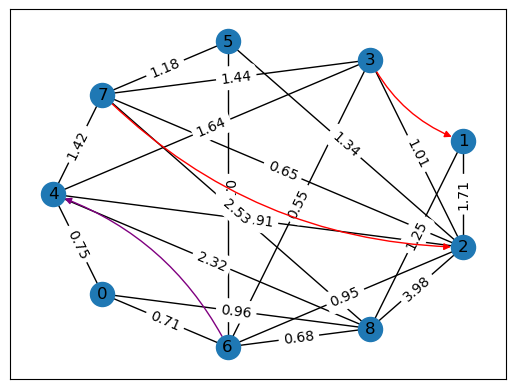

In [7]:
visualize(net)

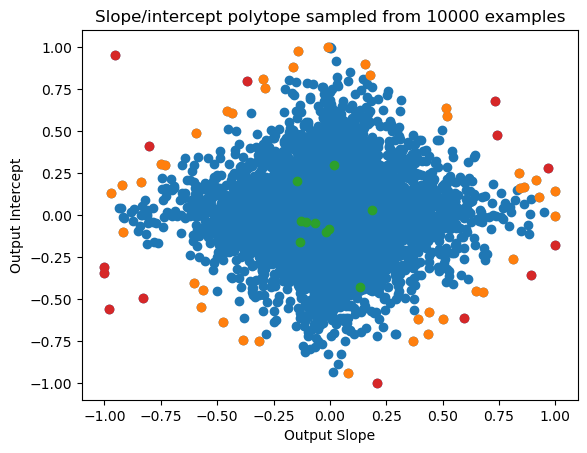

In [9]:
on_slopes = [v[1] for v in on_nets]
on_ints = [v[2] for v in on_nets]
inside_slopes = [v[1] for v in inside_nets]
inside_ints = [v[2] for v in inside_nets]
outside_slopes = [v[1] for v in outside_nets]
outside_ints = [v[2] for v in outside_nets]

plt.scatter(slope_vals, intercept_vals)
plt.scatter(on_slopes, on_ints)
plt.scatter(inside_slopes, inside_ints)
plt.scatter(outside_slopes, outside_ints)
plt.title(f'Slope/intercept polytope sampled from {len(slope_vals)} examples')
plt.xlabel('Output Slope')
plt.ylabel('Output Intercept')
# plt.legend(['All', 'part of soft boundary', 'inside soft boundary (sampled)', 'outside soft boundary'])
# plt.plot(np.arange(-1, 1, 0.1), 1-np.abs(np.arange(-1, 1, 0.1)), 'r', alpha=0.5)
# plt.plot(np.arange(-1, 1, 0.1), -1+np.abs(np.arange(-1, 1, 0.1)), 'r', alpha=0.5)
plt.show()

Text(0.5, 1.0, 'slope = 0.36076209216318755, intercept = -0.15616474189250434')

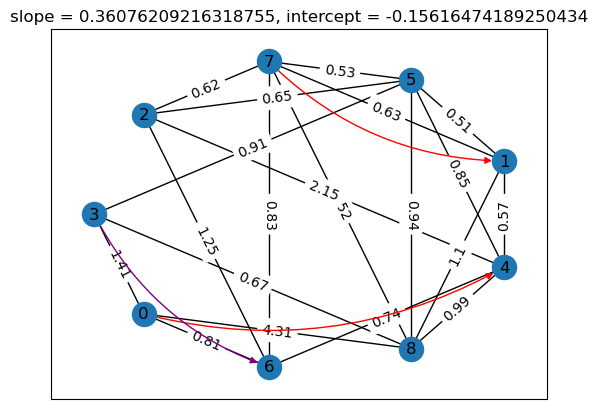

In [81]:
net_arr = inside_nets
i = 3
visualize(net_arr[i][0])
plt.title(f'slope = {net_arr[i][1]}, intercept = {net_arr[i][2]}')

## Experiment with slope/intercept prediction

In [22]:
all_nets = on_nets + inside_nets + outside_nets

X = []
y = []
for net, slope, intercept in all_nets:
    sources = net.inputs + net.outputs
    deg_lst = []
    for s in sources:
        a, b = list(map(int, s.node_names))
        deg_a, deg_b = 0, 0
        for r in net.edges:
            c, d = list(map(int, r.node_names))
            deg_a += int(c == a or d == a)
            deg_b += int(c == b or d == b)
        deg_lst.extend([deg_a, deg_b])
    X.append(deg_lst[:])
    y.append([slope, intercept])

X = np.array(X)
y = np.array(y)

In [89]:
X.shape, y.shape

((10000, 7), (10000, 2))

In [90]:
X[0]

array([3, 4, 5, 4, 4, 2, 5])

In [91]:
w_hat, residuals, rank, sigma = np.linalg.lstsq(X, y)

/var/folders/p1/kynpdwyn2r5fmbpnr8d45m340000gn/T/ipykernel_74194/3911712913.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_hat, residuals, rank, sigma = np.linalg.lstsq(X, y)


In [92]:
w_hat

array([[ 1.13866277e-03, -1.12344896e-03],
       [-2.16717027e-03, -2.29649238e-04],
       [-2.35366795e-03, -2.59065440e-03],
       [-6.19606317e-04, -6.66640811e-06],
       [-2.87822481e-03,  2.06261185e-03],
       [ 1.19750028e-03,  2.23044052e-03],
       [ 3.71105016e-03, -6.12672399e-04]])

In [93]:
preds = X @ w_hat 
preds.shape

(10000, 2)

Text(0, 0.5, 'Predicted slope')

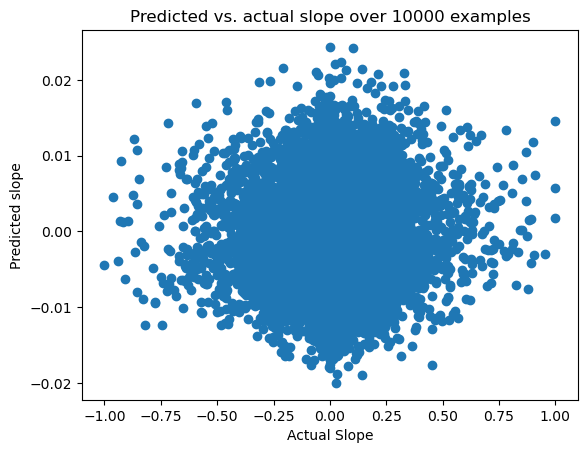

In [94]:
pred_slope = preds[:, 0]
plt.scatter(slope_vals, pred_slope)
plt.title(f'Predicted vs. actual slope over {len(slope_vals)} examples')
plt.xlabel('Actual Slope')
plt.ylabel('Predicted slope')

Text(0, 0.5, 'Predicted intercept')

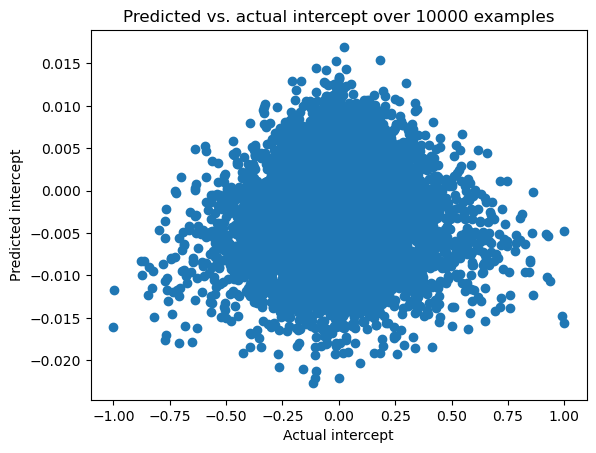

In [95]:
pred_int = preds[:, 1]
plt.scatter(intercept_vals, pred_int)
plt.title(f'Predicted vs. actual intercept over {len(slope_vals)} examples')
plt.xlabel('Actual intercept')
plt.ylabel('Predicted intercept')

In [28]:
residuals

array([24.32176781, 16.20788343])

In [20]:
on_nets[0][0].inputs[0].node_names

['6', '0']